
***
## 5. Inference: how to extract a response from our model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('./')
from seq2seq import seq2seq
from chat_dataset import TextDataset, batchify
import torch
from tqdm import tqdm

In [3]:
# now we put everything on gpu
train_dataset = TextDataset('../data/convai2_simple_train_wpersona_with_starts.txt', device='cuda')
valid_dataset = TextDataset('../data/convai2_simple_valid_wpersona_with_starts.txt', device='cuda', dictionary=train_dataset.shared_dict)

100%|██████████| 7799/7799 [00:00<00:00, 26717.76it/s]


In [4]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=batchify, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, collate_fn=batchify, shuffle=False)

In [5]:
from seq2seq import seq2seq
model = seq2seq(train_dataset.get_vocab_size(), train_dataset.get_vocab_size(), embedding_size=300, dropout=0.3, grad_clip=0.1, hidden_size=512, use_cuda=True, encoder_attention='general', attention_time='pre', lr=0.0001, encoder_shared_lt=True) 

In [8]:
import os
import wget
USE_PRETRAINED = True

if USE_PRETRAINED:
    if not os.path.isfile('./512_pre_35.683342852656736.pt'):
        url='http://ikulikov.name/512_pre_35.683342852656736.pt'
        filename = wget.download(url)
    model.load_model('./512_pre_35.683342852656736.pt')

In [9]:
model

seq2seq(
  (decoder): DecoderRNN(
    (dropout): Dropout(p=0.3)
    (embedding): Embedding(18760, 300, padding_idx=0)
    (gru): GRU(300, 512, num_layers=2, batch_first=True, dropout=0.3)
    (attention): AttentionLayer(
      (linear_in): Linear(in_features=512, out_features=512, bias=False)
      (linear_out): Linear(in_features=812, out_features=300, bias=False)
      (softmax): Softmax()
      (tanh): Tanh()
    )
    (out): Linear(in_features=512, out_features=18760, bias=True)
  )
  (encoder): EncoderRNN(
    (dropout): Dropout(p=0.3)
    (embedding): Embedding(18760, 300, padding_idx=0)
    (gru): GRU(300, 512, num_layers=2, batch_first=True, dropout=0.3)
  )
  (criterion): CrossEntropyLoss()
)

In [10]:
valid_loader = DataLoader(valid_dataset, batch_size=1, collate_fn=batchify, shuffle=True)

# Inference: greedy search

### *On every timestep the token with maximum probability is selected.*

## $$\hat{y}_t = arg\max_{v \in V} \log p(y_t=v|\hat{y}_{<t}, Y_{<l}^s, Y_{<l}^{\bar{s}}, U).$$

- every token is selected from the whole vocabulary list

In [11]:
model.decode_greedy??

Signature: model.decode_greedy(encoder_states, batch_size)
Docstring: <no docstring>
Source:   
    def decode_greedy(self, encoder_states, batch_size):
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        starts = self.sos_buffer.expand(batch_size, 1)  # expand to batch size
        decoder_hidden = encoder_hidden  # no attention yet

        # greedy decoding here        
        preds = [starts]
        scores = []
        
        finish_mask = torch.Tensor([0]*batch_size).byte().to(self.opts['device'])
        xs = starts
        _attn_w_log = []
        
        for ts in range(self.longest_label):
            decoder_output, decoder_hidden, attn_w_log = self.decoder(xs, decoder_hidden, encoder_states)
            _scores, _preds = F.log_softmax(decoder_output, dim=-1).max(dim=-1)
            preds.append(_preds)
            _attn_w_log.append(attn_w_log)
            scores.append(_scores.view(-1)*(finish_mask == 0).float())

            finish

# Greedy search: issues

### Greedy search is suboptimal especially in case of high-entropy output distributions trained with a maximum likelihood approach

## *discuss* --> why is it suboptimal? any particular example?

In [12]:
for i, batch in enumerate(valid_loader):
    out_greedy, dump = model.eval_step(batch, decoding_strategy='greedy', dump=True)
    print('input: {} \n\n\t g {:.{prec}f}: {} \n\n'.format(train_dataset.v2t(batch.text_vecs[0].tolist()),out_greedy[0][1], train_dataset.pred2text(out_greedy[0][0]),  prec=3))
    print()
    if i == 20:
        break

input: i volunteer at the homeless shelter . i enjoy exploring new parts of the city . i play several instruments . my father played violin professionally . i ' m a piano teacher on the side . hey there ! where are you from ? 

	 g -6.292: <sos> i am from the united states 



input: my favorite band is the insane clown posse . i play a lot of call of duty . i drive a ford pinto . on weekends i do live action roleplaying events . hello how are you doing today ? <sep> i am good how are you <sep> i am doing real good . how is the weather this morning ? 

	 g -4.169: <sos> i am good thanks for asking 



input: i am a stunt double as my second job . i was raised in a single parent household . i only eat <unk> . i never broke a bone in my body ever in my life . i ' m so excited i will be graduating high school in a couple years <sep> that ' s great ! are you going to college ? <sep> yes ! i want to be a vegan chef . being vegan is fun ! ! 

	 g -12.144: <sos> i ' m a teacher , i ' m a teac

# Beam search

![beampic](nbimgs/ironbeam.jpeg)

Beam search is a term appeared in 1977 from CMU. It stands for a heuristic search algorithm in graphs. The main idea of a beam search: at each level of a tree it generates all successors of the states at the current level, sorting them in increasing order of heuristic cost but let only top-K best successors to continue.

## Mathematical formulation

Instead of maintaining a single hypothesis at a time, as in greedy search above, beam search maintains $K$ hypotheses:

## $$\mathcal{H}_t = \{ (y_1^1, \dots, y_t^1), \dots, (y_1^K, \dots, y_t^K) \}$$

Each hypothesis is expanded with all possible next tokens $v$ to form candidate hypotheses, each of which is in the form of

## $$\tilde{h}^i_v = (y_1^i, \ldots, y_t^i, v),$$

where $v \in V$. Each candidate is associated with its score:

## $$s(\tilde{h}^i_v) = \sum_{t'=1}^t \log p ( y_{t'}^i | y_{<t'}^i) + \log p(v|y_{\leq t}^i).$$

The new hypothesis set of $K$ hypotheses is then constructed as

## $$\mathcal{H}_{t+1} = \underset{i,v}{\text{arg-top-}k}~~ s(\tilde{h}^i_v).$$

When all the hypotheses in the new hypothesis set have terminated, i.e., $y_{t+1}^i=\left<\text{eos}\right>$ for all $i$, beam search terminates, and the hypothesis with the highest score is returned.
    


## Technical details and implementation: ~IMPORTANT~

In [13]:
from beam import Beam
Beam.__init__??

Signature:
Beam.__init__(
    self,
    beam_size=10,
    min_length=3,
    padding_token=0,
    bos_token=2,
    eos_token=3,
    min_n_best=3,
    device='cpu',
    block_ngram=1,
    expand_beam=1,
)
Docstring: Initialize self.  See help(type(self)) for accurate signature.
Source:   
    def __init__(
        self,
        beam_size=10,
        min_length=3,
        padding_token=PAD_IDX,
        bos_token=SOS_IDX,
        eos_token=EOS_IDX,
        min_n_best=3,
        device="cpu",
        block_ngram=1,
        expand_beam=1,
    ):
        self.beam_size = beam_size
        self.min_length = min_length
        self.min_n_best = min_n_best
        self.eos = eos_token
        self.bos = bos_token
        self.pad = padding_token
        self.device = device

        self.scores = torch.Tensor(self.beam_size).float().zero_().to(self.device)
        self.all_scores = [torch.Tensor([0.0] * beam_size).to(self.device)]
        self.bookkeep = []
        self.outputs = [
            t

assume `beam_size = 5`

`self.outputs = [ [1,1,1,1,1] ]`

`self.scores = [0,0,0,0,0]`

`HypothesisTail = ("timestep", "hypid", "score", "tokenid")`

In [14]:
model.decode_beam??

Signature:
model.decode_beam(
    beam_size,
    batch_size,
    encoder_states,
    block_ngram=0,
    expand_beam=1,
)
Docstring: <no docstring>
Source:   
    def decode_beam(self, beam_size, batch_size, encoder_states, block_ngram=0, expand_beam=1):
        dev = self.opts['device']
        beams = [ Beam(beam_size, device='cuda', block_ngram=block_ngram, expand_beam=expand_beam) for _ in range(batch_size) ]
        decoder_input = self.sos_buffer.expand(batch_size * beam_size, 1).to(dev)
        inds = torch.arange(batch_size).to(dev).unsqueeze(1).repeat(1, beam_size).view(-1)
        
        encoder_states = self.reorder_encoder_states(encoder_states, inds)  # not reordering but expanding
        incr_state = encoder_states[1]
        
        for ts in range(self.longest_label):
            if all((b.done() for b in beams)):
                break
            score, incr_state, attn_w_log = self.decoder(decoder_input, incr_state, encoder_states)
            score = score[:, -1:,

# Main beam routines happen in advance function

In [15]:
Beam.advance??

Signature: Beam.advance(self, softmax_probs)
Docstring: <no docstring>
Source:   
    def advance(self, softmax_probs):
        voc_size = softmax_probs.size(-1)
        current_length = len(self.all_scores) - 1
        if current_length < self.min_length:
            # penalize all eos probs to make it decode longer
            for hyp_id in range(softmax_probs.size(0)):
                softmax_probs[hyp_id][self.eos] = -NEAR_INF

        if len(self.bookkeep) == 0:
            # the first step we take only the first hypo into account since all
            # hypos are the same initially
            beam_scores = softmax_probs[0]
        else:
            beam_scores = softmax_probs + self.scores.unsqueeze(1).expand_as(
                softmax_probs
            )

        for i in range(self.outputs[-1].size(0)):
            if self.do_block_ngram(i, self.block_ngram):
                beam_scores[i] = -NEAR_INF

        flatten_beam_scores = beam_scores.view(-1)  # [beam_size * voc_siz

### There are many places where bugs can occur on the way. Visualization of the beam tree is an efficient way of checking that everything is fine. And we have it!

# Lets do some beam search!

In [18]:
import graphviz

In [19]:
valid_loader = DataLoader(valid_dataset, batch_size=2, collate_fn=batchify, shuffle=True)

def show_beam_tree(beam_obj, n_best, dataset):
    return graphviz.Source(beam_obj.get_beam_dot(dictionary=dataset, n_best=n_best))

beam_size = 5
block_ngram = 1
expand_beam = 10

for i, batch in enumerate(valid_loader):
    out_beam, beam = model.eval_step(batch, decoding_strategy='beam:{}:{}:{}'.format(beam_size, block_ngram, expand_beam))
    print('b {}, {:.{prec}f} {}'.format(beam_size, out_beam[0][1],train_dataset.pred2text(out_beam[0][0]),  prec=3))
    out_greedy, dump = model.eval_step(batch, decoding_strategy='greedy', dump=True)
    print('g {:.{prec}f}: {}'.format(out_greedy[0][1], train_dataset.pred2text(out_greedy[0][0]),  prec=3))
    print()
    
    #import ipdb; ipdb.set_trace()
    if i == 10:
        break

b 5, -5.022 <sos> do you have any pets ?
g -8.225: <sos> i ' ve a dog , he ' s a cat .

b 5, -7.207 <sos> no i don ' t have any pets
g -8.614: <sos> i ' ve a dog , he ' s a golden retriever

b 5, -7.005 <sos> i ' m sorry to hear that , do you have any hobbies ?
g -11.546: <sos> i ' m sorry to hear that , i ' m a little old person

b 5, -5.913 <sos> what do you do for a living ?
g -14.643: <sos> i love the outdoors . i ' m a huge fan of thrones .

b 5, -5.809 <sos> i ' m sorry to hear that .
g -5.809: <sos> i ' m sorry to hear that .

b 5, -5.160 <sos> what kind of music do you like ?
g -11.765: <sos> that ' s cool i ' m a teacher and i ' m a teacher

b 5, -8.810 <sos> i ' m not sure what you mean .
g -9.350: <sos> i ' m not sure what i want to do when i was younger .

b 5, -7.505 <sos> i do like to read . what do you do for a living ?
g -12.782: <sos> i do like to read . i ' m a huge fan of the country .

b 5, -5.448 <sos> sounds fun ! what do you do for a living ?
g -11.362: <sos> tha

## Checking the processed Beam sctructures

In [20]:
beam[0].outputs

[tensor([2, 2, 2, 2, 2], device='cuda:0'),
 tensor([  5, 385, 164, 217,  16], device='cuda:0'),
 tensor([ 46,  28,  60,  24, 384], device='cuda:0'),
 tensor([  58, 2156, 7430, 2388,   14], device='cuda:0'),
 tensor([ 388,   14,   10, 7430,   22], device='cuda:0'),
 tensor([ 634,    5,   10,   89, 4083], device='cuda:0'),
 tensor([10,  5, 28,  5, 89], device='cuda:0'),
 tensor([ 5, 29, 28, 46, 28], device='cuda:0'),
 tensor([ 28,  46,  29,  14, 310], device='cuda:0'),
 tensor([29, 95, 14, 55, 14], device='cuda:0'),
 tensor([ 14,   7, 125,  55,  95], device='cuda:0'),
 tensor([  7, 724,  40,  14, 214], device='cuda:0'),
 tensor([ 40,  10,  14,  16, 491], device='cuda:0'),
 tensor([  14,    3,  267, 4302,  634], device='cuda:0'),
 tensor([ 594, 2601,   19,   24,  419], device='cuda:0'),
 tensor([ 10, 434,  16,  14,  10], device='cuda:0'),
 tensor([  3,   3,  22,  17, 129], device='cuda:0')]

In [21]:
beam[0].bookkeep

[tensor([0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 2, 1, 3, 4], device='cuda:0'),
 tensor([1, 0, 0, 0, 2], device='cuda:0'),
 tensor([1, 0, 3, 0, 2], device='cuda:0'),
 tensor([0, 2, 3, 4, 1], device='cuda:0'),
 tensor([0, 2, 1, 3, 4], device='cuda:0'),
 tensor([0, 2, 1, 1, 3], device='cuda:0'),
 tensor([0, 0, 2, 1, 4], device='cuda:0'),
 tensor([0, 1, 2, 2, 4], device='cuda:0'),
 tensor([0, 1, 0, 0, 0], device='cuda:0'),
 tensor([4, 3, 1, 2, 1], device='cuda:0'),
 tensor([0, 1, 4, 4, 3], device='cuda:0'),
 tensor([0, 1, 2, 3, 4], device='cuda:0'),
 tensor([0, 0, 1, 1, 3], device='cuda:0'),
 tensor([0, 1, 2, 2, 4], device='cuda:0'),
 tensor([0, 4, 1, 2, 3], device='cuda:0')]

In [22]:
beam[0].all_scores

[tensor([0., 0., 0., 0., 0.], device='cuda:0'),
 tensor([-0.6041, -2.4544, -2.6713, -3.6808, -3.8927], device='cuda:0'),
 tensor([-1.3947, -3.2586, -4.3353, -5.1454, -5.8454], device='cuda:0'),
 tensor([-3.2833, -4.1461, -4.6843, -4.7111, -6.1260], device='cuda:0'),
 tensor([-5.2081, -5.4807, -5.9569, -6.4697, -6.7323], device='cuda:0'),
 tensor([-5.2583, -7.2313, -7.6166, -9.0706, -9.3332], device='cuda:0'),
 tensor([ -5.9376,  -9.1776,  -9.3206, -10.1278, -11.3526], device='cuda:0'),
 tensor([ -7.7717,  -9.7162, -11.1402, -11.3990, -11.6416], device='cuda:0'),
 tensor([ -9.4977,  -9.8458, -11.5360, -12.4626, -12.9978], device='cuda:0'),
 tensor([ -9.8439, -12.8188, -14.4149, -14.4189, -14.7544], device='cuda:0'),
 tensor([-12.8083, -12.9726, -13.1147, -13.1228, -13.2310], device='cuda:0'),
 tensor([-13.3507, -14.4206, -14.6746, -15.0216, -15.4770], device='cuda:0'),
 tensor([-15.1009, -16.2743, -17.4067, -17.6898, -17.7166], device='cuda:0'),
 tensor([-15.7278, -17.1814, -19.7260, -2

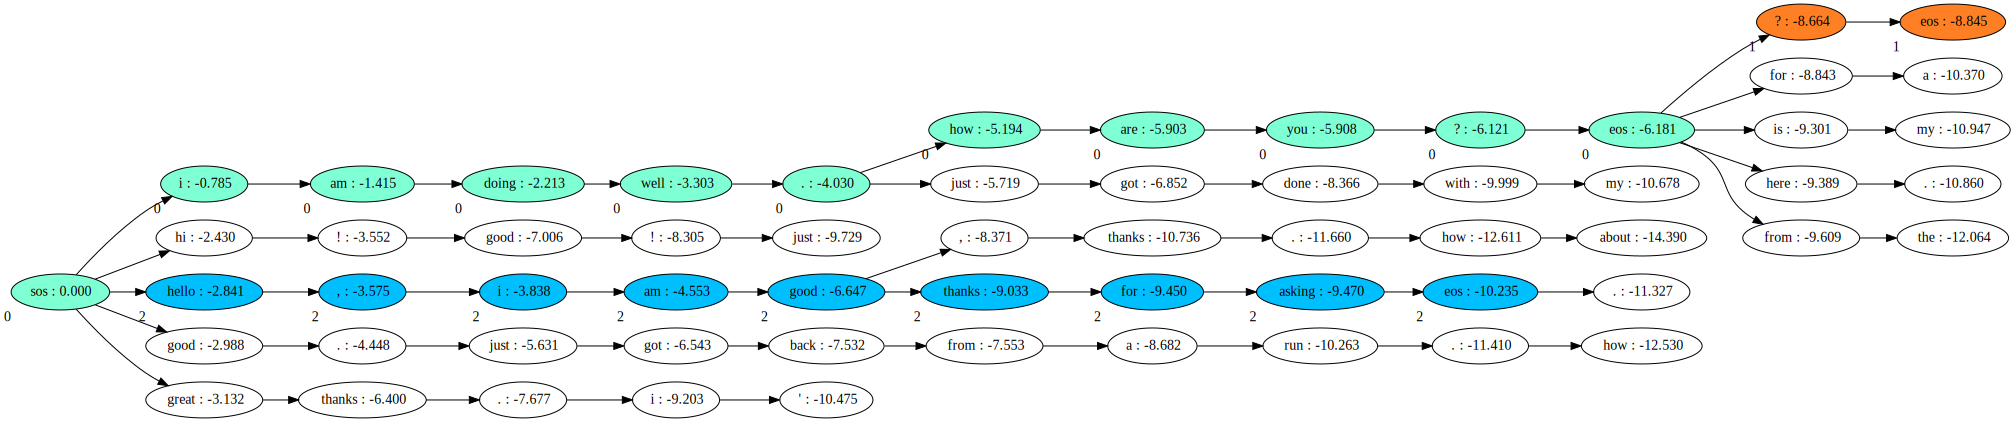

In [23]:
show_beam_tree(beam[1], 3, train_dataset)

## *discuss* <-- what can we say about that tree? 

# Important heuristics: repetetive ngram blocking

In [24]:
Beam.do_block_ngram??

Signature: Beam.do_block_ngram(self, i, n)
Docstring: <no docstring>
Source:   
    def do_block_ngram(self, i, n):
        if n > 0:
            for n_gram in range(2, n + 1):
                current_hypo = self.partial_hyps[i, 1:]
                ngrams = set()
                gram = []
                for l in range(len(current_hypo)):
                    gram = (gram + [current_hypo[l].item()])[-n_gram:]
                    if tuple(gram) in ngrams:
                        return True
                    else:
                        ngrams.add(tuple(gram))
        return False
File:      ~/ammi-2019-nlp/03-day/beam.py
Type:      function


# Important heuristics: length penalty

In [25]:
Beam.get_length_penalty??

Signature: Beam.get_length_penalty(length)
Docstring: <no docstring>
Source:   
    @staticmethod
    def get_length_penalty(length):
        return math.pow((1 + length) / 6, 0.65)
File:      ~/ammi-2019-nlp/03-day/beam.py
Type:      function


# Important heuristics: expanding the beam during the selection. ref: [pdf](https://pdfs.semanticscholar.org/febf/7c3b532ceb029fe17a0e1c43ec84c308a781.pdf)

In [26]:
valid_loader = DataLoader(valid_dataset, batch_size=2, collate_fn=batchify, shuffle=True)

beam_size = 10
block_ngram = 5
expand_beam = 20

for i, batch in enumerate(valid_loader):
    out_beam_expanded, beam_expanded = model.eval_step(batch, decoding_strategy='beam:{}:{}:{}'.format(beam_size, block_ngram, expand_beam))
    print('b expanded {}, {:.{prec}f} {}'.format(beam_size, out_beam_expanded[0][1],train_dataset.pred2text(out_beam_expanded[0][0]),  prec=3))
    
    out_beam, beam = model.eval_step(batch, decoding_strategy='beam:{}:{}:{}'.format(beam_size, block_ngram, 1))
    print('b {}, {:.{prec}f} {}'.format(beam_size, out_beam[0][1],train_dataset.pred2text(out_beam[0][0]),  prec=3))
    
    print()
    if i == 10:
        break

b expanded 10, -5.277 <sos> what do you do for a living ?
b 10, -8.696 <sos> thank you . i ' m going to be a doctor .

b expanded 10, -4.604 <sos> i am from california , where are you from ?
b 10, -4.225 <sos> i am from california , how about you ?

b expanded 10, -6.712 <sos> sure . what else do you like to do ?
b 10, -6.733 <sos> that ' s true . what do you do for fun ?

b expanded 10, -6.045 <sos> i ' m sorry to hear that . what else do you like to do ?
b 10, -5.888 <sos> i ' m sorry to hear that . what do you do for fun ?

b expanded 10, -4.722 <sos> what do you do for a living ?
b 10, -6.314 <sos> do you have any hobbies ?

b expanded 10, -4.818 <sos> do you have any pets ?
b 10, -4.818 <sos> do you have any pets ?

b expanded 10, -4.936 <sos> what kind of work do you do ?
b 10, -5.358 <sos> do you have any pets ?

b expanded 10, -4.965 <sos> what do you do for a living ?
b 10, -6.461 <sos> do you have any hobbies ?

b expanded 10, -7.903 <sos> do you have any pets ? i have a dog 

# simple beam

In [27]:
min_n_best=5
n_best_beams = [b.get_rescored_finished(n_best=min_n_best) for b in beam]
n_best_beam_preds_scores = []
for i, beamhyp in enumerate(n_best_beams):
    this_beam = []
    for hyp in beamhyp:
        pred = beam[i].get_pretty_hypothesis(
            beam[i].get_hyp_from_finished(hyp))
        score = hyp.score
        this_beam.append((pred, score))
    n_best_beam_preds_scores.append(this_beam)

for pred, score in n_best_beam_preds_scores[0]:
    print(train_dataset.pred2text(pred))

<sos> thank you . what do you do for a living ?
<sos> thank you . what do you do for fun ?
<sos> thank you . what do you do for work ?
<sos> thank you . what do you do for a living
<sos> thank you . what do you do for fun


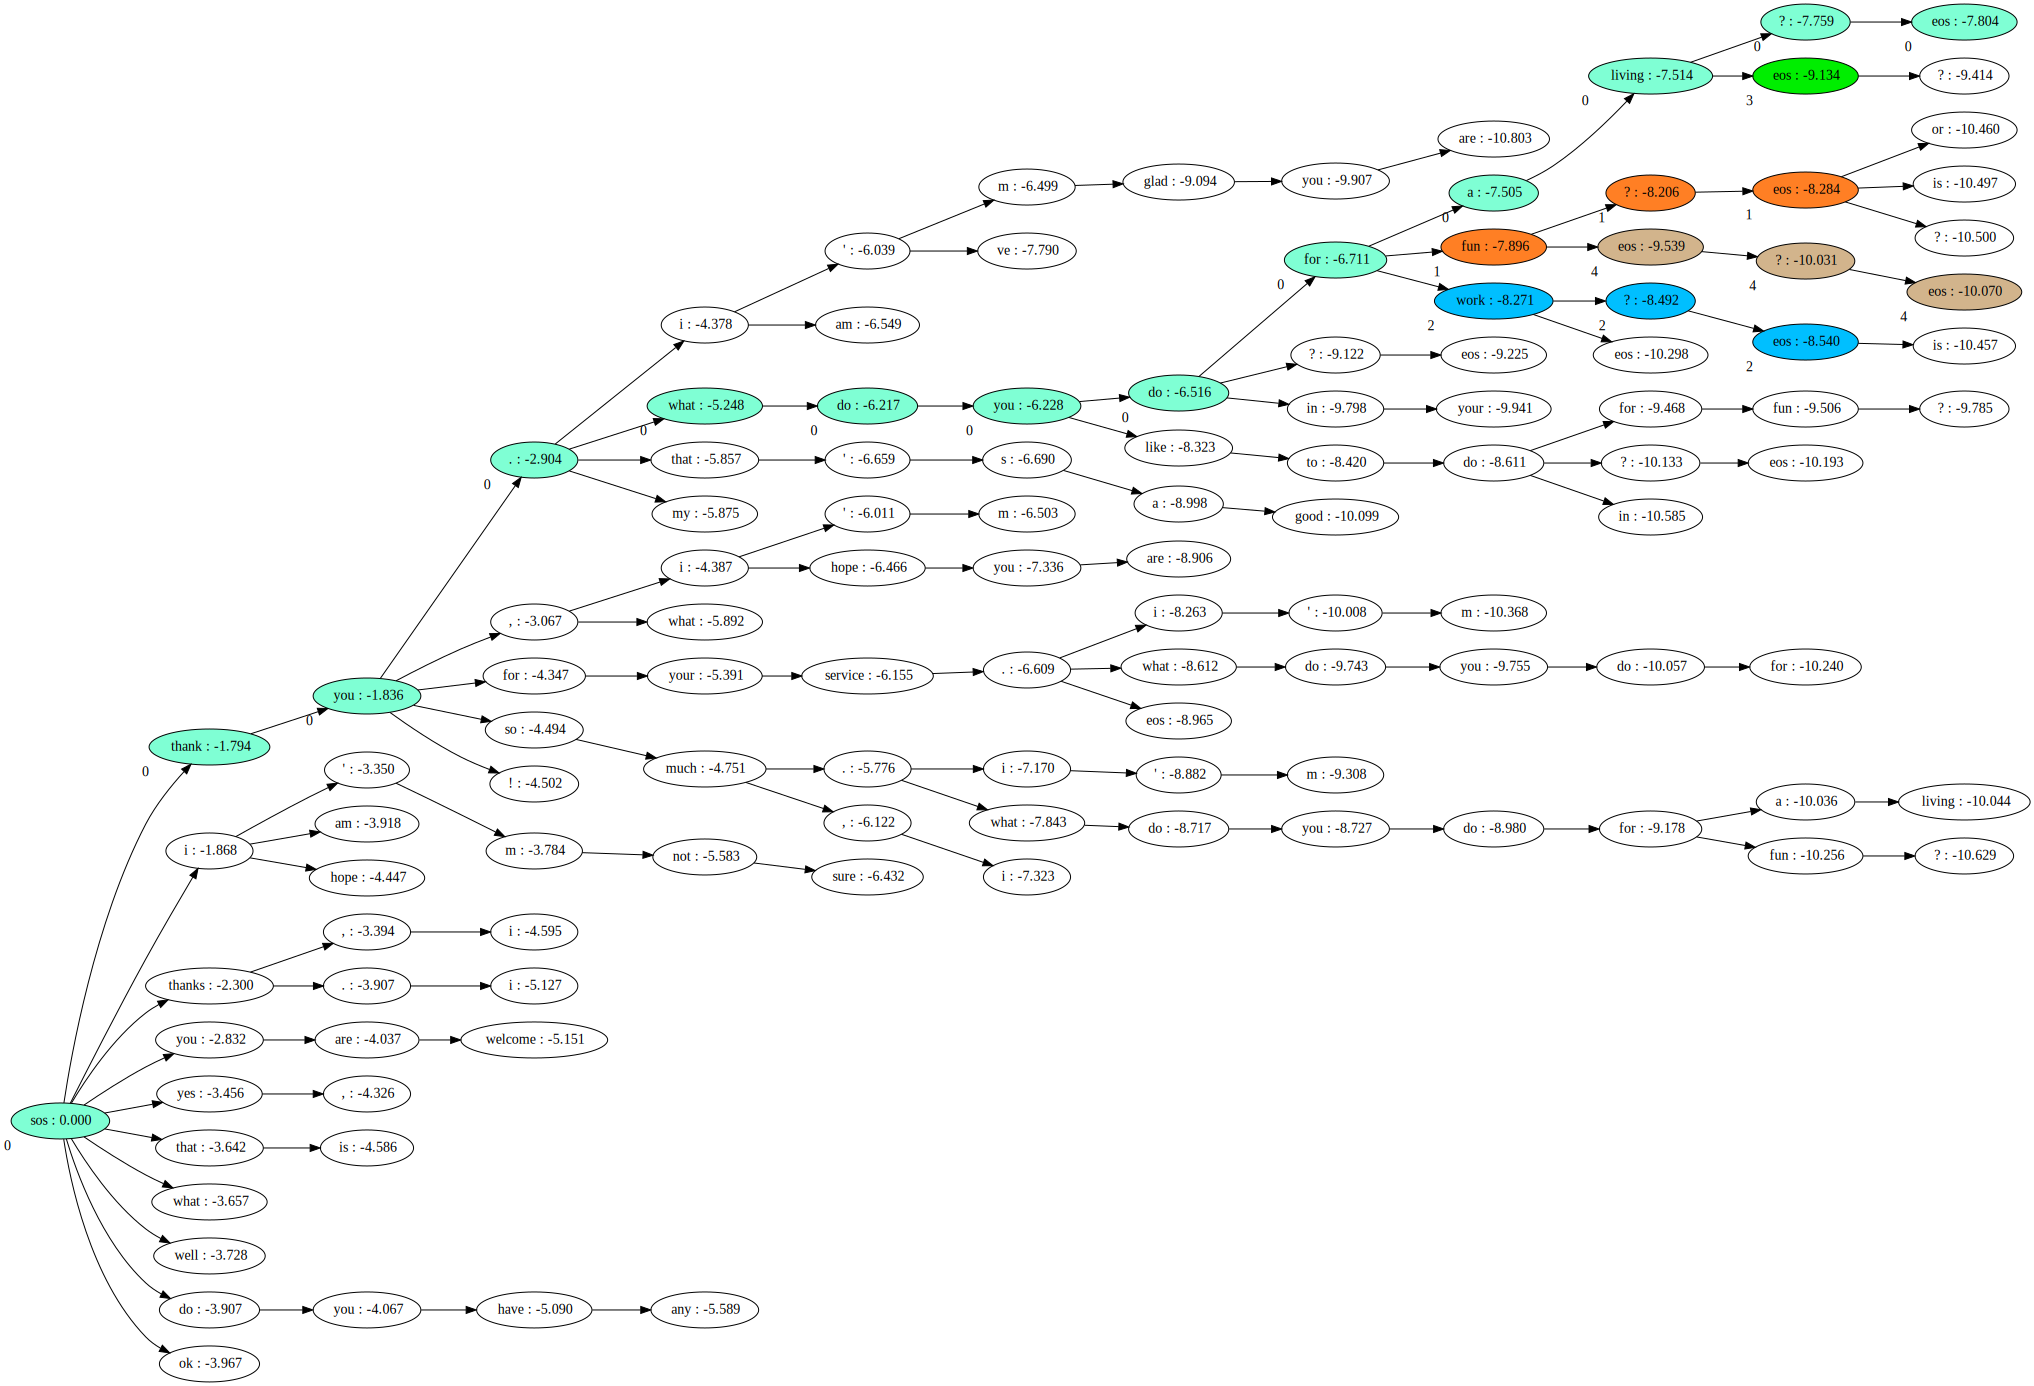

In [28]:
show_beam_tree(beam[0], 5, train_dataset)

# expanded beam

In [29]:
min_n_best=5
n_best_beams = [b.get_rescored_finished(n_best=min_n_best) for b in beam_expanded]
n_best_beam_preds_scores = []
for i, beamhyp in enumerate(n_best_beams):
    this_beam = []
    for hyp in beamhyp:
        pred = beam_expanded[i].get_pretty_hypothesis(
            beam_expanded[i].get_hyp_from_finished(hyp))
        score = hyp.score
        this_beam.append((pred, score))
    n_best_beam_preds_scores.append(this_beam)

for pred, score in n_best_beam_preds_scores[0]:
    print(train_dataset.pred2text(pred))

<sos> what do you do for a living ?
<sos> what do you do for a living ?
<sos> i ' m not sure what that means .


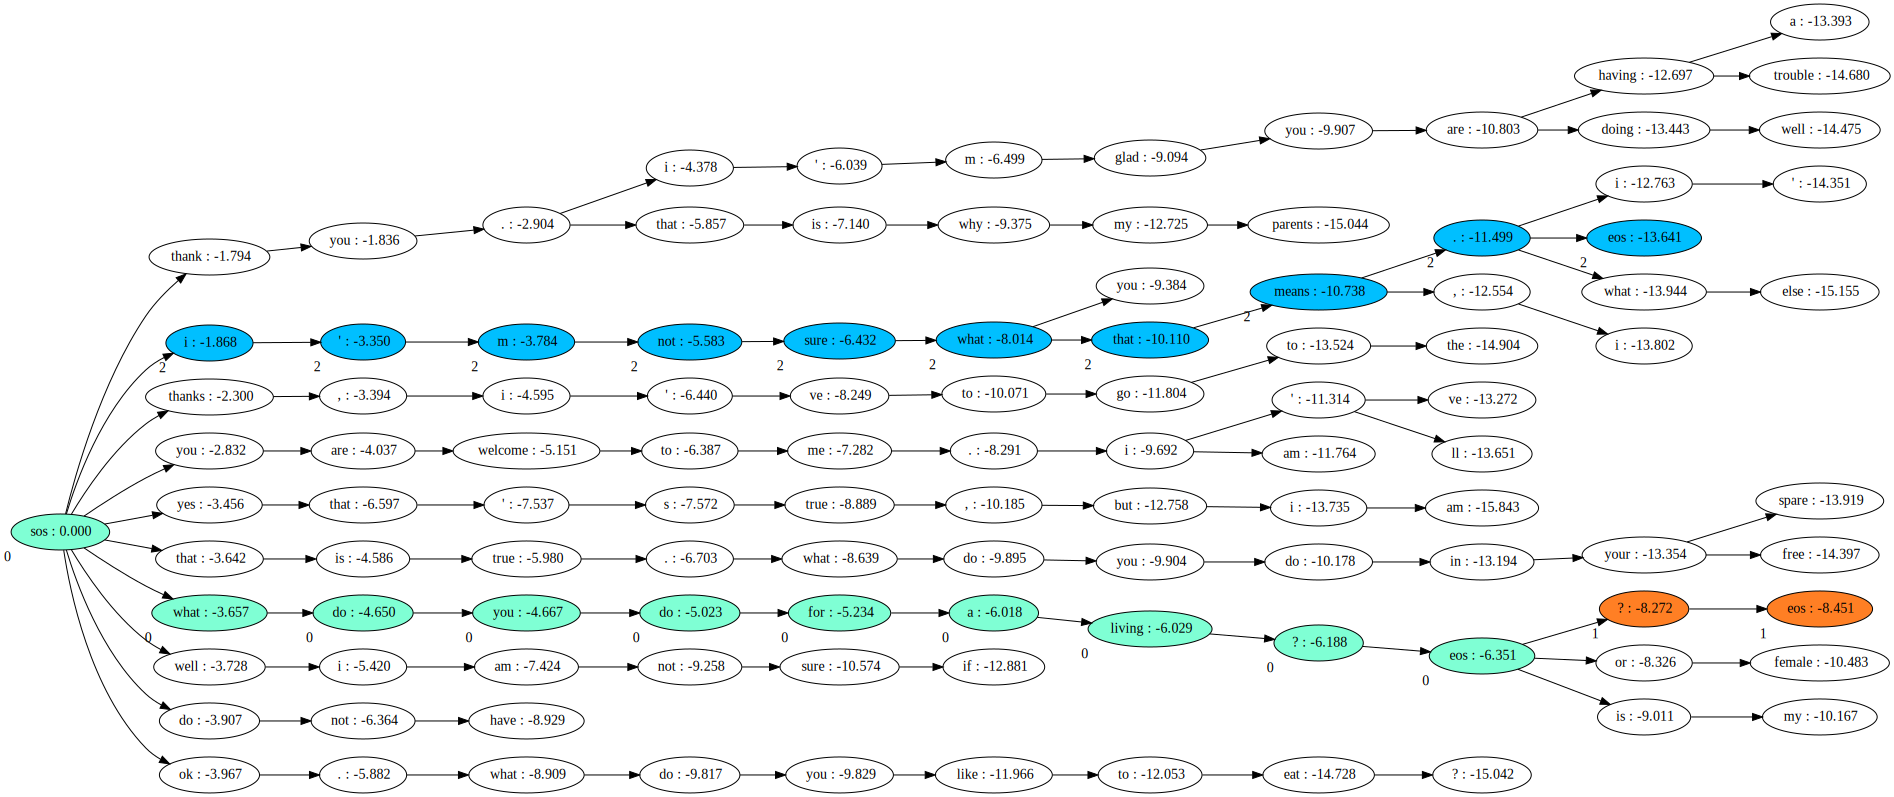

In [30]:
show_beam_tree(beam_expanded[0], 5, train_dataset)

# LETS CHAT

In [31]:
import re
from chat_dataset import Batch

def start_chat(model, context, train_dataset, use_cuda=True):
    RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)
    
    device = 'cuda' if use_cuda else 'cpu'
    user_input = ''
    history = train_dataset.t2v(RETOK.findall(context))
    while user_input != 'exit':
        user_input = input()
        user_input = user_input.lower()
        history.extend([train_dataset.word2ind['<sep>']] + train_dataset.t2v(RETOK.findall(user_input)))
        batch = Batch(text_vecs=torch.Tensor([history]).long().to(device), text_lens=[len(history)], label_vecs=None, label_lens=None, use_packed=False)
        beam_pred_scores, beam = model.eval_step(batch, decoding_strategy='beam:5:5:10')
        print(train_dataset.pred2text(beam_pred_scores[0][0]))
        history.extend([train_dataset.word2ind['<sep>']] + beam_pred_scores[0][0].tolist()[1:-1])
        #print('history: {}'.format(train_dataset.v2t(history)))

In [32]:
model_persona = 'i live in nyc. i am russian. i like riding bicycle. my hobby is judo.'

start_chat(model, model_persona, train_dataset)

 hey there!


<sos> how are you ?


 exit


<sos> what do you do for a living ?
